Daniël van der Schuur - 1811230  
Jonas Moons - Fundamentals of Machine Learning  
08-06-2022  

In [1]:
import json 
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np # linear algebra
import seaborn as sns
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans #The k-means algorithm

## To do

- [ ] Create DF for individual players
- [ ] Create DF for team composition per map
- [ ] Calculate relative performance per player (x) agent
- [ ] Create linear regression model
- [ ] Create Naive Bayes model
- [ ] Interpret results of graphs
- [ ] # zet de data om naar uur voor de x as op de linear regression plot



# Predictive Model - Team Composition in Valorant

## Introduction
The concept revolves around Valorant, a tactical 5-man team shooter.The game consists of rounds, and the team that gets 13 rounds first wins.  
The game consists of an array of variables, what characters (agents) the team picks (every character has a set of unique abilities), the role each agent fulfills, the map being played, and personal performance. By gathering data from my personal team, the predictive model will seek out the team composition that will have the highest impact on the game.

The game currently has 20 agents categorized in 4 roles being:  
- Duelist - The abilities of agents under this role focus on being the first to enter sites and engage the enemy.
- Initiator - The abilities of agents under this role focus on flushing enemies out of hiding spots and corners in order to assist the team when charging into battle.
- Controller - The abilities of agents under this role allow them to assist their teammates by cutting enemy vision, taking control of an area, and forcing enemies into choke points.
- Sentinel - The abilities of agents under this role focus on defensive play, with emphasis on supporting the rest of the team through providing intel, anchoring down sites, and preventing the enemy from flanking.

## Data set
Data is scraped from tracker.gg a website that gives insight into games played, specifically from Valorant (e.g. https://tracker.gg/valorant/profile/riot/sjonkie%23bluk/overview).  
The webscraper using selenium can be found here: https://github.com/sjerrietukkel/val_tracker_scraper  

The data represents games played by an individual player, every player will have around 100 games, due to a limitation of the scraper. The final dataset (700 rows) consists of every player combined and will thus represent the team effort and performance. The data sets used represent the 5-stack team that I personally play with. 

### Data Merging

In [2]:
def merge_JsonFiles(): # Merge all data files in to one
    result = list()
    for filename in glob.glob('priv_data/*.json', recursive=False):
        with open(filename, 'r') as infile:
            result.extend(json.load(infile))
    with open('priv_data/combined/combined_matches.json', 'w') as output_file:
        json.dump(result, output_file)
total_matches = merge_JsonFiles()

df = pd.read_json('priv_data/combined/combined_matches.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  575 non-null    int64  
 1   map                 575 non-null    object 
 2   agent               575 non-null    object 
 3   class               575 non-null    object 
 4   time                575 non-null    object 
 5   mode                575 non-null    object 
 6   score_won           575 non-null    int64  
 7   score_lost          575 non-null    int64  
 8   win                 575 non-null    bool   
 9   placement           575 non-null    int64  
 10  kills               575 non-null    int64  
 11  deaths              575 non-null    int64  
 12  assists             575 non-null    int64  
 13  kd_percentage       575 non-null    float64
 14  hs_percentage       575 non-null    int64  
 15  damage_per_round    575 non-null    int64  
 16  combat_s

# Feature Engineering

### Time of game started

The time of the game bing started needed reformatting in order to be useful for Seaborn graphs.  
I choose to give it the current date, since only the time of playing was included in the scraper, not the date of the game.

In [3]:
# turn time into 24 hour format without date
df['time'] = pd.to_datetime(df['time'])
df.drop(["mode"] , axis=1, inplace=True) # not relevant since only competitive games were scraped

### Calculate difference in score

Since not every win/loss is equal, I want to differentiate between larger differences in final scores.

In [4]:
# Calculates team perfomance based on the difference in score
df["result_diff"] = df["score_won"] - df["score_lost"]
df.drop(["score_won", "score_lost"] , axis=1, inplace=True)

def score_indication(score_diff):
    if score_diff > 5:
        return "big win"
    elif score_diff < -5:
        return "big loss"
    elif score_diff > 0:
        return "win"
    elif score_diff < 0:
        return "loss"
    else:
        return "draw"

df["result_indication"] = df["result_diff"].apply(score_indication)
df.head(3)

,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication
0,1,Icebox,Sova,Initiator,2022-06-10 21:19:00,True,8,10,11,4,0.9,11,119,157,BoomeRRemoveR,7,big win
1,2,Bind,Chamber,Sentinel,2022-06-10 20:27:00,False,5,17,20,7,0.8,12,146,214,BoomeRRemoveR,-2,loss
2,3,Bind,Sova,Initiator,2022-06-10 22:16:00,False,7,14,17,7,0.8,11,125,188,BoomeRRemoveR,-4,loss


### Relative performance indicator per class

Since some classes are more "active" in their playstyle, I choose to give an indication on perfomance relative to the classes played. 



In [5]:
# get average combat score per class
def get_avg_combat_score_per_class(df, class_name):
    return df[df["class"] == class_name]["combat_score_total"].mean()

# store average combat score per class in a dictionary
avg_combat_score_per_class_dict = {}
for class_name in df["class"].unique():
    avg_combat_score_per_class = get_avg_combat_score_per_class(df, class_name)
    avg_combat_score_per_class_dict[class_name] = int(avg_combat_score_per_class)

print(avg_combat_score_per_class_dict)


{'Initiator': 196, 'Sentinel': 204, 'Duelist': 225, 'Controller': 232}


In [6]:
# add performance indicator to dataframe based on combat score and class average
def performance_indication(combat_score_total, class_name):
    if combat_score_total > (avg_combat_score_per_class_dict[class_name] + (avg_combat_score_per_class_dict[class_name] / 2)):
        return "++"
    elif combat_score_total > avg_combat_score_per_class_dict[class_name]:
        return "+"
    elif combat_score_total < (avg_combat_score_per_class_dict[class_name] - (avg_combat_score_per_class_dict[class_name] / 2)):
        return "--"
    elif combat_score_total < avg_combat_score_per_class_dict[class_name]:
        return "-"
    else:
        return "="

df["performance_indication"] = df.apply(lambda row: performance_indication(row["combat_score_total"], row["class"]), axis=1)
df.tail(10)


,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication,performance_indication
565,68,Bind,Sage,Sentinel,2022-06-10 22:15:00,False,8,9,15,2,0.6,8,102,168,LookinGreenToday,-9,big loss,-
566,69,Breeze,Sage,Sentinel,2022-06-10 21:17:00,False,8,17,21,9,0.8,34,116,166,LookinGreenToday,0,draw,-
567,70,Haven,Sage,Sentinel,2022-06-10 20:28:00,False,9,13,18,5,0.7,13,108,174,LookinGreenToday,-2,loss,-
568,71,Fracture,Sage,Sentinel,2022-06-10 22:57:00,False,9,13,20,3,0.7,14,107,158,LookinGreenToday,-2,loss,-
569,72,Ascent,Killjoy,Sentinel,2022-06-10 22:08:00,False,4,18,19,2,0.9,7,141,216,LookinGreenToday,-2,loss,+
570,73,Haven,Killjoy,Sentinel,2022-06-10 21:29:00,False,8,9,16,1,0.6,18,107,150,LookinGreenToday,-6,big loss,-
571,74,Breeze,Sage,Sentinel,2022-06-10 21:05:00,True,10,5,13,8,0.4,7,40,65,LookinGreenToday,3,win,--
572,75,Split,Sage,Sentinel,2022-06-10 22:16:00,False,4,17,16,7,1.1,7,131,235,LookinGreenToday,-6,big loss,+
573,76,Bind,Sage,Sentinel,2022-06-10 21:29:00,True,10,9,15,9,0.6,18,96,150,LookinGreenToday,5,win,-
574,77,Breeze,Sage,Sentinel,2022-06-10 20:30:00,True,10,10,17,5,0.6,9,73,125,LookinGreenToday,5,win,-


In [28]:
# get data per map 
def get_map_data(df, map_name):
    return df[df["map"] == map_name]

# get data per agent 
def get_agent_data(df, agent_name):
    return df[df["agent"] == agent_name]
    
# get data per username
def get_username_data(df, username):
    return df[df["username"] == username] 

br_df = get_map_data(df, "Ascent")
br_df.tail()


,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication,performance_indication
542,45,Ascent,Sage,Sentinel,2022-06-10 13:47:00,True,7,10,11,10,0.9,9,96,147,LookinGreenToday,7,big win,-
550,53,Ascent,Sage,Sentinel,2022-06-10 22:12:00,True,5,18,18,7,1.0,16,150,235,LookinGreenToday,3,win,+
559,62,Ascent,Sage,Sentinel,2022-06-10 20:16:00,True,8,16,16,10,1.0,14,124,195,LookinGreenToday,4,win,-
562,65,Ascent,Reyna,Duelist,2022-06-10 14:40:00,False,2,17,14,2,1.2,18,190,287,LookinGreenToday,-8,big loss,+
569,72,Ascent,Killjoy,Sentinel,2022-06-10 22:08:00,False,4,18,19,2,0.9,7,141,216,LookinGreenToday,-2,loss,+


In [8]:
# # calculate most likely to win agent composition for each map   
# def get_agent_composition(df, map_name):
#     map_df = get_map_data(df, map_name)
#     agent_composition = {}
#     for agent in map_df["agent"].unique():
#         # calculate the percentage of wins for each agent
#         agent_composition[agent] = map_df[map_df["agent"] == agent]["win"].mean()
#         # agent_composition[agent] = len(get_agent_data(map_df, agent))
#     return agent_composition

# get_agent_composition(df, "Ascent")

## Data Exploration
### Correlation Matrix
The number varies from -1 to 1.

1 means that there is a 1 to 1 relationship (a perfect correlation)

0.9 is also a good relationship, and if you increase one value, the other will probably increase as well.

-0.9 would be just as good relationship as 0.9, but if you increase one value, the other will probably go down.

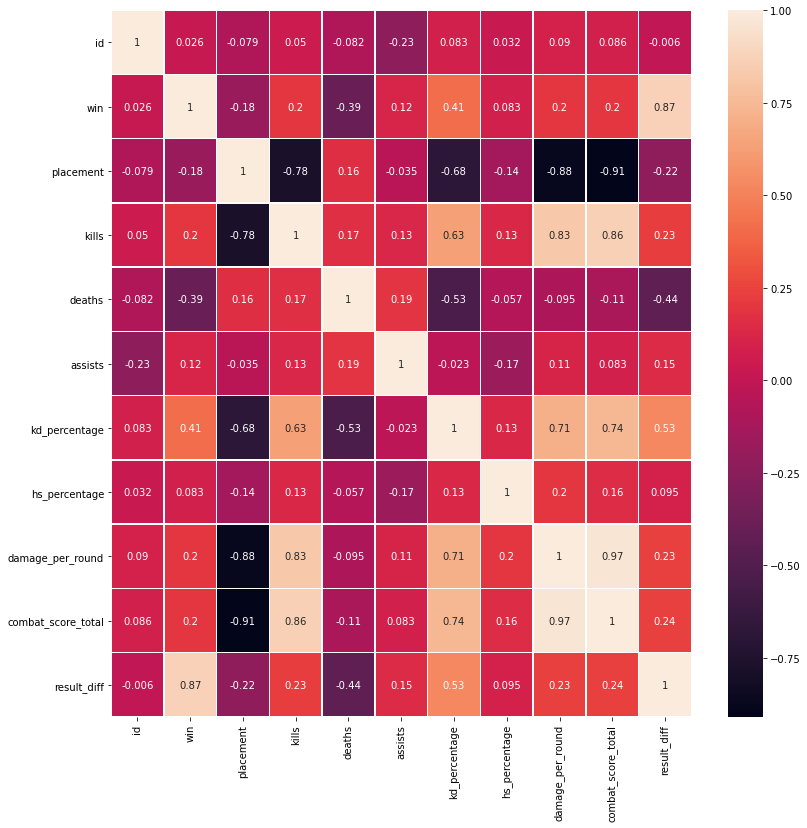

In [9]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(correlation_mat, annot = True, linewidths=.5, ax=ax)
plt.show()

### Time based performance
I wanted to see if there was a correlation between the time of when a game is played vs the individual combat score


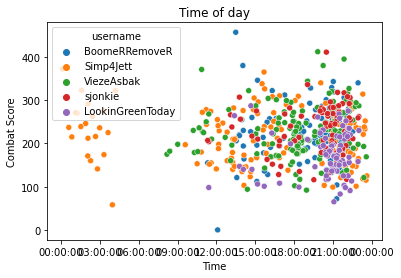

In [10]:
ax = sns.scatterplot(data=df, x='time', y='combat_score_total', hue='username')
ax.set_title('Time of day')
ax.set_xlabel('Time')
ax.set_ylabel('Combat Score')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()


In [33]:
# zet de data om naar uur voor de x as op de linear regression plot


# get linear regression model of combat score vs time
# def get_combat_score_vs_time_model(df):
#     X = df['time'].values.reshape(-1, 1)
#     y = df['combat_score_total'].values
#     model = LinearRegression()
#     model.fit(X, y)
#     return model

# md = get_combat_score_vs_time_model(df)
# # evaluate model
# y_pred = md.predict(df['time'].values.reshape(-1, 1))
# print(r2_score(df['combat_score_total'], y_pred))


/var/folders/1z/6_wrx8t5705flg608_w1lcs80000gn/T/ipykernel_85621/3154802142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_df["time"] = pd.to_datetime(hour_df["time"])
/var/folders/1z/6_wrx8t5705flg608_w1lcs80000gn/T/ipykernel_85621/3154802142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_df["hour"] = hour_df["time"].dt.hour


In [12]:
# get winrate per map
def get_winrate_per_map(df, map_name):
    return df[df["map"] == map_name]["win"].mean()

# show win rate per map 
for map_name in df["map"].unique():
    print("{} win rate: {}".format(map_name, get_winrate_per_map(df, map_name)))

Icebox win rate: 0.5869565217391305
Bind win rate: 0.391304347826087
Haven win rate: 0.4861111111111111
Ascent win rate: 0.5853658536585366
Split win rate: 0.5116279069767442
Fracture win rate: 0.5070422535211268
Breeze win rate: 0.5875


In [13]:
# calculate average combat score per username
def get_avg_combat_score(df, username):
    return df[df["username"] == username]["combat_score_total"].mean()

# see which class every username uses the most
def get_most_used_class(df, username):
    return df[df["username"] == username]["class"].mode()[0]

def most_used_agents(df, username):
    temp = df[df["username"] == username]["agent"].value_counts()
    temp = temp / len(df["agent"].unique())
    temp = temp * 100
    # only return agents with more than 10% of the total
    return temp[temp > 50].index.tolist()


def performance_calc(df, username, agent):
    i = 0
    if df[df["username"] == username]["performance_indication"].all() == "++":
        i = i + 2
    elif df[df["username"] == username]["performance_indication"].all() == "=":
        i = i + 0
    elif df[df["username"] == username]["performance_indication"].all() == "--":
        i = i - 1
    elif df[df["username"] == username]["performance_indication"].all() == "+":
        i = i + 2
    elif df[df["username"] == username]["performance_indication"].all() == "-":
        i = i - 1
    return i

username_dict = {}
# store every usenrmae in username_dict
for username in df["username"].unique():
    username_dict[username] = {}
    username_dict[username]["avg_combat_score"] = int(get_avg_combat_score(df, username))
    username_dict[username]["most_used_class"] = get_most_used_class(df, username)
    username_dict[username]["most_used_agents"] = most_used_agents(df, username)

# print(username_dict)
user_df = pd.read_json(json.dumps(username_dict))
user_df.head()

,BoomeRRemoveR,Simp4Jett,ViezeAsbak,sjonkie,LookinGreenToday
avg_combat_score,216,213,229,234,173
most_used_class,Sentinel,Duelist,Duelist,Controller,Sentinel
most_used_agents,"[Chamber, Sova, Fade, Breach]","[Jett, Chamber, Reyna]","[Reyna, Chamber, Killjoy, Sage]","[Omen, Brimstone]",[Sage]


In [32]:
# win percentage per username per map
def get_agent_win_percentage_per_username_per_map(df, username, map_name):
    return df[(df["username"] == username) & (df["map"] == map_name)]["win"].mean()

for each in df["username"].unique():
    for map_name in df["map"].unique():
        # attadch to username_dict
        username_dict[each][map_name] = get_agent_win_percentage_per_username_per_map(df, each, map_name)

user_df = pd.read_json(json.dumps(username_dict))
user_df.head(10)

,BoomeRRemoveR,Simp4Jett,ViezeAsbak,sjonkie,LookinGreenToday
avg_combat_score,216,213,229,234,173
most_used_class,Sentinel,Duelist,Duelist,Controller,Sentinel
most_used_agents,"[Chamber, Sova, Fade, Breach]","[Jett, Chamber, Reyna]","[Reyna, Chamber, Killjoy, Sage]","[Omen, Brimstone]",[Sage]
Icebox,0.55,0.571429,0.5,0.727273,0.692308
Bind,0.294118,0.444444,0.409091,0.5,0.25
Haven,0.5,0.421053,0.555556,0.538462,0.4
Ascent,0.545455,0.684211,0.6,0.454545,0.6
Split,0.636364,0.380952,0.47619,0.5,0.6
Fracture,0.5,0.588235,0.391304,0.625,0.555556
Breeze,0.647059,0.55,0.611111,0.5,0.615385


In [45]:
# calculate winrate per agent per map
def get_winrate_per_agent_per_map(df, username, agent, map_name):
    return df[(df["agent"] == agent) & (df["username"] == username) & (df["map"] == map_name)]["win"].mean()

print(get_winrate_per_agent_per_map(df, "sjonkie", "Brimstone", "Ascent"))


0.2


In [47]:
print(username_dict["sjonkie"]["most_used_agents"])

{'avg_combat_score': 234, 'most_used_class': 'Controller', 'most_used_agents': ['Omen', 'Brimstone'], 'Icebox': 0.7272727272727273, 'Bind': 0.5, 'Haven': 0.5384615384615384, 'Ascent': 0.45454545454545453, 'Split': 0.5, 'Fracture': 0.625, 'Breeze': 0.5}


In [14]:
# fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
# ax1.plot(df['time'], df['combat_score_total'], '.', label = 'Combat Score')
# # x axis 24 hour format
# ax1.set_xticks(np.arange(0, 24, 1))
# ax1.set_xticklabels(np.arange(0, 24, 1))
# # ax1.xaxis.set_major_locator(md.HourLocator(interval = 1))
# # hue = username

# ax1.set_xlabel('Time (24 hour format)')
# ax1.set_ylabel('Combat Score')
# ax1.legend()

# fig.autofmt_xdate(rotation = 0)

In [15]:
# sns.pairplot(data = df[['kills', 'deaths', 'combat_score_total', 'win', 'damage_per_round', 'agent', 'map', 'hs_percentage', 'username']], hue = 'username')

In [16]:
# x = df[['hs_percentage']] 
# y = df['combat_score_total']
# lm = LinearRegression() 
# lm.fit(x, y)

# b0 = lm.intercept_ #gets the intercept
# b1 = lm.coef_[0] #lm.coef_ gets a list of coefficients (excluding the intercept). [0] gets the actual number from the list

# print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") #.0f formats to 3 decimals.

In [17]:
# sns.lmplot(x='hs_percentage', y='combat_score_total', data=df)
# plt.title('')
# plt.xlabel("Headshot Percentage")
# plt.ylabel("Combat Score Total")
# plt.show()

In [18]:
# sns.lmplot(
#     x='kills',
#     y='combat_score_total',
#     hue="username",
#     palette="Set1",
#     row="map",
#     data=df
# )
# plt.title('')
# plt.xlabel("kills")
# plt.ylabel("combat score total")
# plt.show()

# Predictive Model

### Random Forest

In [19]:
# X = df[['kills', 'deaths', 'assists', 'damage_per_round', 'combat_score_total', 'score_diff', 'hs_percentage', 'kd_percentage']] #This gets all the columns from Time to Amount
# y = df['map']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
# rf = RandomForestClassifier(n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
# rf = rf.fit(X_train, y_train)

In [21]:
# rf.score(X_test,y_test)

In [22]:
# rf.predict([[10, 10, 10, 100, 200, 2, 15, 1.0]])

In [23]:
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(X_train,y_train)

In [24]:
# feature_imp = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
# feature_imp

In [25]:
# %matplotlib inline
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.legend()
# plt.show()

### K-Means

In [26]:
# sns.scatterplot(x=df["hs_percentage"], y=df["combat_score_total"], style=df["username"])

In [27]:
# km = KMeans(n_clusters=3) #create a new k-means model with 3 clusters
# X = df[['hs_percentage','damage_per_round', 'combat_score_total', 'kills']] #get the X variables from the dataframe
# km = km.fit(X) #calculate the cluster centers
# df['cluster'] = km.predict(X) #predict the clusters of each observation and store in the dataframe
# df.head()

# sns.scatterplot(x=df["combat_score_total"], y=df["hs_percentage"], style=df["username"], hue=df["cluster"])
